# Ratio Swap

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pytz

In [2]:
# Adjusting the start and end times
frequency = "1d"
start_time = (datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=700)).strftime('%Y-%m-%d')  
end_time = datetime.now(pytz.timezone('US/Pacific')).strftime('%Y-%m-%d')  # Current date in UTC

In [3]:
# Define your tickers, start time, end time, and frequency
tickers = ["BTC-CAD", "ETH-CAD", "ETH-CAD", "ETH-BTC", "SOL-BTC", "SOL-CAD", "SOL-ETH"
          ]

# Retrieve historical data and adjust to Pacific Time
historical_data = {}
for ticker in tickers:
    data = yf.download(ticker, start=start_time, end=end_time, interval=frequency)[['Close']]
    #data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')  # Convert timezone to Pacific Time
    historical_data[ticker] = data

# Combine data without weights
combined_data = pd.DataFrame()
for ticker, data in historical_data.items():
    for col in data.columns:
        combined_column_name = f"{ticker}_{col}"  # Create a unique column name for each 'High' and 'Low'
        combined_data[combined_column_name] = data[col]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
combined_data.dropna(inplace=True)
combined_data.columns

Index(['BTC-CAD_Close', 'ETH-CAD_Close', 'ETH-BTC_Close', 'SOL-BTC_Close',
       'SOL-CAD_Close', 'SOL-ETH_Close'],
      dtype='object')

In [15]:
import pandas as pd

# Assuming combined_data is correctly set up with 'ETH-BTC_Close', 'BTC-CAD_Close', and 'ETH-CAD_Close'

rolling_avg = 30 # Adjust this if you meant to use a different period for the moving average

# Calculate the moving average and the thresholds
combined_data['rolling_avg'] = combined_data['ETH-BTC_Close'].rolling(window=rolling_avg).mean()
combined_data['rolling_avg_below'] = combined_data['rolling_avg'] * 0.95
combined_data['rolling_avg_above'] = combined_data['rolling_avg'] * 1.05

# Initialize BTC and ETH holdings
btc_held = 0
eth_held = 10  # Start with 1 ETH

# Initialize a counter for the number of trades
trade_counter = 0

# Commission fee per trade (0.5%)
commission_fee = 0

# Store the ETH-CAD price at the start
eth_cad_start_price = combined_data.iloc[0]['ETH-CAD_Close']

# Loop through the DataFrame to execute the strategy
for i, row in combined_data.iterrows():
    eth_btc_ratio = row['ETH-BTC_Close']
    ma_rolling = row['rolling_avg']
    ma_rolling_below = row['rolling_avg_below']
    ma_rolling_above = row['rolling_avg_above']

    # Buy ETH condition (when the ETH-BTC ratio is below the moving average threshold)
    if eth_btc_ratio < ma_rolling_below and btc_held > 0:
        # Convert all BTC holdings to ETH based on the current ETH-BTC ratio, accounting for commission
        eth_bought = (btc_held / eth_btc_ratio) * (1 - commission_fee)
        eth_held += eth_bought
        btc_held = 0
        trade_counter += 1  # Increment trade counter

    # Sell ETH and Buy BTC condition (when the ETH-BTC ratio is above the moving average threshold)
    elif eth_btc_ratio > ma_rolling_above and eth_held > 0:
        # Convert all ETH holdings to BTC based on the current ETH-BTC ratio, accounting for commission
        btc_bought = (eth_held * eth_btc_ratio) * (1 - commission_fee)
        btc_held += btc_bought
        eth_held = 0
        trade_counter += 1  # Increment trade counter

# Final conversion of BTC back to ETH if any BTC is held
if btc_held > 0:
    # Convert remaining BTC holdings back to ETH, accounting for commission
    final_eth_bought = (btc_held / combined_data.iloc[-1]['ETH-BTC_Close']) * (1 - commission_fee)
    eth_held += final_eth_bought
    btc_held = 0

# Store the ETH-CAD price at the end
eth_cad_end_price = combined_data.iloc[-1]['ETH-CAD_Close']

# Calculate the total value at the start and at the end
total_value_start = 10*eth_cad_start_price  # Since you started with 1 ETH
total_value_end = eth_held * eth_cad_end_price

# Calculate the difference in value
value_difference = total_value_end - total_value_start

print(f"Final ETH held after executing the strategy: {eth_held} ETH")
print(f"Final BTC held after executing the strategy: {btc_held} BTC")

print(f"Total number of trades executed: {trade_counter}")
print(f"ETH-CAD price at start: {eth_cad_start_price} CAD")
print(f"ETH-CAD price at end: {eth_cad_end_price} CAD")
print(f"Total value at start: {total_value_start} CAD")
print(f"Total value at end: {total_value_end} CAD")
print(f"Difference in value: {value_difference} CAD")


Final ETH held after executing the strategy: 12.197498177130472 ETH
Final BTC held after executing the strategy: 0 BTC
Total number of trades executed: 13
ETH-CAD price at start: 3925.044921875 CAD
ETH-CAD price at end: 4005.79443359375 CAD
Total value at start: 39250.44921875 CAD
Total value at end: 48860.670301719154 CAD
Difference in value: 9610.221082969154 CAD


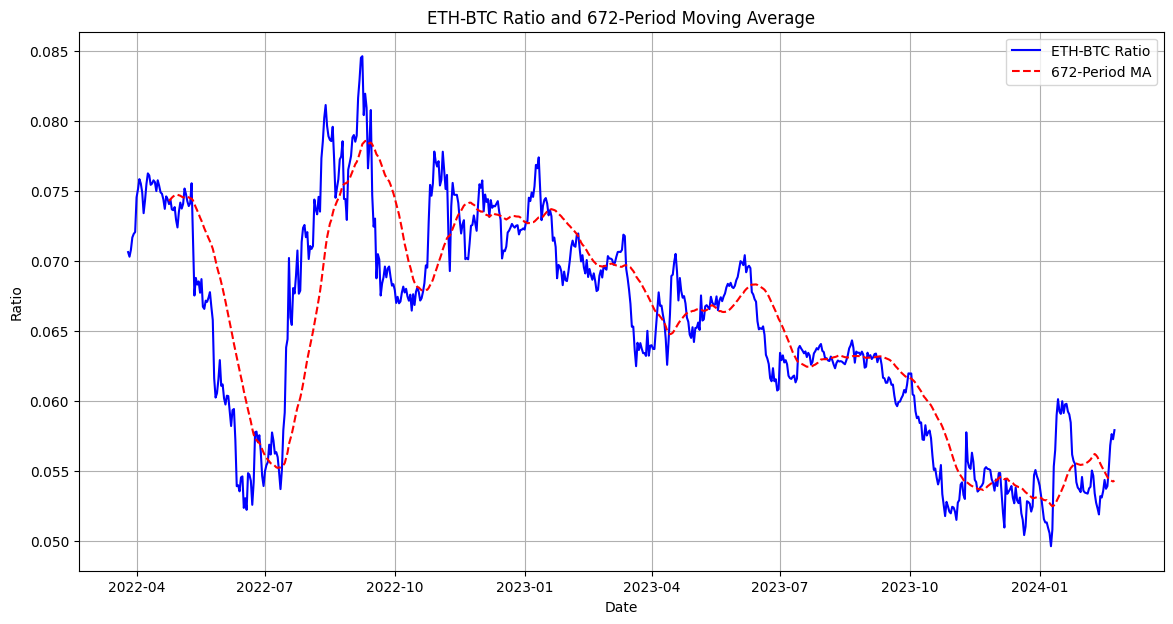

In [6]:
import matplotlib.pyplot as plt

# Assuming combined_data already has the 'rolling_avg' column calculated
# If not, uncomment the following line to calculate it
# combined_data['rolling_avg'] = combined_data['ETH-BTC_Close'].rolling(window=672).mean()

plt.figure(figsize=(14, 7))  # Set the figure size for better readability

# Plot ETH-BTC closing ratio
plt.plot(combined_data.index, combined_data['ETH-BTC_Close'], label='ETH-BTC Ratio', color='blue')

# Plot the 672-period moving average
plt.plot(combined_data.index, combined_data['rolling_avg'], label='672-Period MA', color='red', linestyle='--')

# Add some plot decorations
plt.title('ETH-BTC Ratio and 672-Period Moving Average')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [7]:
# Calculate the absolute difference between the 672-MA and the ETH-BTC ratio
combined_data['Abs_Diff'] = abs((combined_data['ETH-BTC_Close'] - combined_data['rolling_avg'])/combined_data['rolling_avg'])

# Calculate the average of these absolute differences
average_abs_diff = combined_data['Abs_Diff'].mean()*100
average_abs_diff

3.9851571375926262